# 7장. 딥러닝을 위한 고급도구


## 7.1 Sequential 모델을 넘어서: 케라스의 함수형 
이전까지의 모든 신경망은 Sequential 모델을 사용하여 만듦  
Sequential 모델은 네트워크 입력과 출력이 하나라고 가정함  
이 가정을 많은경우에 적절하지만 아닌 경우도 있음  

다양한 입력에 대한 하나의 출력  
하나의 입력에 대한 다양한 출력  
이 경우가 위 가설에 해당되지 않음  

이를 처리하는 선형적이지 않은 네트워크 토폴로지가 필요했고  
이를 처리하고자 만든 모듈이 **인셉션** 모듈, **잔차 연결**을 추가한 모듈 임  

또한 여러 경우에 다중 입력 모델, 다중 출력 모델, 그래프 구조를 띤 모델이 필요한데  
이를 케라스 Sequential 클래스를 사용해 만들 수 없어 유연한 **함수형 API**를 활용해 만듦  

### 함수형 API 소개
**함수와 같이 텐서를 직접 입력받고 출력함**   


In [ ]:
from keras import Input, layers

input_tensor = Input(shape=(32,))
dense = layers.Dense(32, activation='relu')

output_tensor = dense(input_tensor)

In [ ]:
from keras.models import Sequential, Model
from keras import layers
from keras import Input

# Sequential 모델
seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,)))
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))

# 함수형 API
input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = Model(input_tensor, output_tensor)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


케라스는 input_tensor에서 output_tensor로 가는 데 필요한 모든 층을 추출하고  
이들을 모아 그래프 데이터 구조인 Model 객체 만듦  

이때, 관련되지 않은 입력과 출력으로 모델을 만들면 RuntimeError 발생

In [ ]:
unrelated_input = Input(shape=(32,))
bad_model = model = Model(unrelated_input, output_tensor)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name='input_1'),
name='input_1', description="created by layer 'input_1'") at layer "dense".
The following previous layers were accessed without issue: []



Model 객체를 컴파일, 훈련, 평가는 Sequential과 동일

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy')

import numpy as np

x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10))

model.fit(x_train, y_train, epochs=10, batch_size=128)

score = model.evaluate(x_train, y_train)

Epoch 1/10
8/8 [==============================] - 1s 2ms/step - loss: 11.9844
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 12.6066
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 14.0575
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 16.6015
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 19.7529
Epoch 6/10
8/8 [==============================] - 0s 2ms/step - loss: 22.9754
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 26.4561
Epoch 8/10
8/8 [==============================] - 0s 2ms/step - loss: 31.0202
Epoch 9/10
8/8 [==============================] - 0s 2ms/step - loss: 35.5158
Epoch 10/10
32/32 [==============================] - 0s 2ms/step - loss: 46.0221


### 다중 입력 모델
함수형 API는 다중 입력 모델을 만드는데 사용할 수 있음  
일반적으로 이런 모델은 다른 입력 가지를 합치기 위해 여러 텐서를 연결할 수 있는 층을 사용함  

이런 다중 입력 모델의 간단한 예는  
질문-응답 모델  
- 자연어 질문
- 답변에 필요한 정보가 담겨있는 텍스트

In [ ]:
# 2개의 입력을 가진 질문-응답 모델의 함수형 API 구현하기
from keras.models import Model
from keras import layers
from keras import Input

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

text_input = Input(shape=(None, ), dtype='int32', name='text')
embedded_text = layers.Embedding(text_vocabulary_size, 64)(text_input)
encoded_text = layers.LSTM(32)(embedded_text)

question_input = Input(shape=(None, ), dtype='int32', name='question')
embedded_question = layers.Embedding(question_vocabulary_size, 64)(question_input)
encoded_question = layers.LSTM(32)(embedded_question)

concatenated = layers.concatenate([encoded_text, encoded_question])

answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)

model = Model([text_input, question_input], answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
question (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 64)     640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 64)     640000      question[0][0]                   
____________________________________________________________________________________________

입력이 2개인 모델을 훈련시키는 방법
- 넘파이 배열의 리스트 주입
- 입력 이름과 넘파이 배열로 이루어진 딕셔너리를 모델의 입력으로 주입

In [ ]:
# 다중 입력 모델에 데이터 주입하기
import numpy as np
from keras.utils import to_categorical

num_samples = 1000
max_length = 100

text = np.random.randint(1, text_vocabulary_size, size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size, size=(num_samples, max_length))

answers = np.random.randint(0, answer_vocabulary_size, size=num_samples)

answers = to_categorical(answers)

model.fit([text, question], answers, epochs=10, batch_size=128)
model.fit({'text':text, 'question':question}, answers, epochs=10, batch_size=128)

Epoch 1/10
8/8 [==============================] - 4s 147ms/step - loss: 6.2146 - acc: 0.0016
Epoch 2/10
8/8 [==============================] - 1s 143ms/step - loss: 6.1951 - acc: 0.1204
Epoch 3/10
8/8 [==============================] - 1s 140ms/step - loss: 6.1456 - acc: 0.0388
Epoch 4/10
8/8 [==============================] - 1s 139ms/step - loss: 6.0293 - acc: 0.0094
Epoch 5/10
8/8 [==============================] - 1s 138ms/step - loss: 5.9387 - acc: 0.0152
Epoch 6/10
8/8 [==============================] - 1s 136ms/step - loss: 5.7988 - acc: 0.0168
Epoch 7/10
8/8 [==============================] - 1s 138ms/step - loss: 5.6984 - acc: 0.0381
Epoch 8/10
8/8 [==============================] - 1s 137ms/step - loss: 5.6151 - acc: 0.0508
Epoch 9/10
8/8 [==============================] - 1s 139ms/step - loss: 5.5071 - acc: 0.0514
Epoch 10/10
8/8 [==============================] - 1s 137ms/step - loss: 5.4173 - acc: 0.0605
Epoch 1/10
8/8 [==============================] - 3s 142ms/step - los

### 다중 출력 모델
다중 출력 모델의 간단한 예  
소셜 미디어 익명의 포스트를 입력으로 받아 나이, 성별, 소득 수준을 예측하기  


In [ ]:
# 3개의 출력을 가진 함수형 API 구현하기
from keras import layers
from keras import Input
from keras.models import Model
vocabulary_size = 50000
num_income_groups = 10

posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(vocabulary_size, 256)(posts_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)

age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups, activation='softmax', name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)

model = Model(posts_input, [age_prediction, income_prediction, gender_prediction])

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 128)    163968      embedding_8[0][0]                
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, None, 128)    0           conv1d[0][0]                     
____________________________________________________________________________________________

이런 모델을 훈련시키기 위해선 네트워크 출력마다 다른 손실 함수를 지정해야 함  
- 나이 : 스칼라 회귀  
- 성별 : 이진 클래스 문제
- 소득 수준 : 다중 클래스 문제

경사 하강법은 하나의 스칼라 값을 최소화하기 때문에 모델을 훈련하라면 이 손실들을 하나의 값으로 합쳐야 함  
손실 값을 합치는 가장 간단한 방법은 모두 더하는 것  


In [ ]:
# 다중 출력 모델의 컴파일 옵션 다중 손실
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])
model.compile(optimizer='rmsprop',
              loss={'age':'mse',
                    'income':'categorical_crossentropy',
                    'gender':'binary_crossentropy'})

하지만, 손실 값이 많이 불균형하면 모델이 개별 손실이 가장 큰 작업에 치우쳐 표현을 최적화 함  
이를 해결하기 위해 최종 손실에 기여하는 수준을 지정할 수 있음  


In [ ]:
# 다중 출력 모델의 컴파일 옵션:손실 가중치
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights=[0.25, 1., 10.])

model.compile(optimizer='rmsprop',
              loss={'age':'mse',
                    'income':'categorical_crossentropy',
                    'gender':'binary_crossentropy'},
              loss_weights={'age':0.25,
                            'income':1.,
                            'gender':10.})

In [ ]:
# 다중 출력 모델에 데이터 주입하기
model.fit(posts, [age_targets, income_targets, gender_targets], epochs=10, batch_size=64)

model.fit(posts, {'age' : age_targets, 'incomde' : income_targets, 'gender' : gender_targets}, epochs=10, batch_size=64)

### 층으로 구성된 비순환 유향 그래프
함수형 API를 사용하면 다중 입력이나 다중 출력 모델뿐 아니라 내부 토폴로지가 복잡한 네트워크도 만들 수 있음  
**비순환 유향 그래프**도 만들 수 있음  
- 인셉션 모듈
- 잔차 연결

#### 인셉션 모듈
**네트워크 안의 네트워크 구조**  
GoogleLeNet 이라고 부르며  
나란히 분리된 가지를 따라 모듈을 쌓아 독립된 작은 네트워크 처럼 구성 함  
가장 기본적인 인셉션 모듈 형태는 3~4개의 가지를 가지는데  
1x1 합성곱으로 시작해 3x3 합성곱이 뒤따르고 마지막에 전체 출력 특성이 합쳐짐  
이런 구성은 네트워크가 따로따로 공간 특성과 채널 방향의 특성을 학습하도록 도움  

In [ ]:
# 함수형 API를 사용하여 인셉션 모듈 구현
from keras import layers
branch_a = layers.Conv2D(128, 1, activation = 'relu', strides=2)(x)

branch_b = layers.Conv2D(128, 1, activation='relu')(x)
branch_b = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_b)

branch_c = layers.AveragePooling2D(3, strides=2)(x)
branch_c = layers.Conv2D(128, 3, activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, activation='relu')(x)
branch_d = layers.Conv2D(128, 3, activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_d)

output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis = -1)

인셉션 V3 전체 구조는 케라스 `keras.applications.inception_v3.InceptionV3` 에 준비 돼 있으며  
ImageNet 데이터셋에서 사전 훈련된 가중치를 포함 함  
극단적인 인셉션 모델인 **억셉션**도 케라스 애플리케이션 모듈에 포함 돼 있음  

#### 잔차 연결
**그래프 형태의 네트워크 컴포넌트로 그래디언트 소실과 표현 병목을 해결할 수 있음**  
일반적으로 10개 층 이상을 가진 모델에 잔차 연결을 추가하면 도움이 됨


### 층 가중치 공유
함수형 API의 중요한 기능은 층 객체를 여러번 재사용 할 수 있다는 점  
층 객체를 두 번 호출하면 새로 만들지 않고 각 호출에 동일한 가중치를 재사용함  
이런 기능 때문에 공유 가지를 가진 모델을 만들 수 있음  

In [ ]:
# 케라스의 함수형 API 공유 층을 사용하는 모델
from keras import layers
from keras import Input
from keras.models import Model

lstm = layers.LSTM(32)
left_input = Input(shape=(None, 128))
left_output = lstm(left_input)

right_input = Input(shape=(None, 128))
right_output = lstm(right_input)

merged = layers.concatenate([left_output, right_output], axis = -1)
predictions = layers.Dense(1, activation='sigmoid')(merged)

model = Model([left_input, right_input], predictions)
model.fit([left_data, right_data], targets)

### 층과 모델
함수형 API에서는 모델을 층처럼 사용할 수 있음  
이 말은 입력 텐서로 모델을 호출해서 출력 텐서를 얻을 수 있다는 뜻으로   
Sequential 클래스와 Model 클래스 모두에서 동일 함  



## 7.2 케라스 콜백과 텐서보드를 사용한 딥러닝 모델 검사와 모니터링
대규모 데이터셋에서 `model.fit()`이나 `model.fit_generator()`로 수십 번의 에포크를 실행하게 되면 중간에 이를 제어할 수 없음  

나쁜 결과가 나오지 않게 사전에 제어해주는 방법  
- 콜백 사용


### 콜백을 사용하여 모델의 훈련 과정 제어하기
지금까지 예제는 적절한 훈련 에포크를 알아내기 위해 첫 번째 실행에서 과대적합이 시작될 때 까지 충분한 에포크로 훈련 함  
그 이후 최적의 에포크만큼 재 훈련 했는데 이는 시간적 낭비가 심함  

이를 처리하는 방법은 검증 손실이 더 이상 향상되지 않을 때 훈련을 멈추게 하는 것  
이를 콜백을 통해 구현할 수 있음  

콜백을 사용하는 사례
- 모델 체크포인트 저장
- 조기 종료
- 훈련하는 동안 하이퍼파라미터 값을 동적으로 조정
- 훈련과 검증 지표를 로그에 기록하거나 모델이 학습한 표현이 업데이트될 때마다 시각화

#### ModelCheckpoint와 EarlyStopping 콜백
EarlyStopping 콜백을 사용하면 정해진 에포크 동안 모니터링 지표가 향상되지 않을 때 훈련을 중지하게 됨  
일반적으로 이 콜백은 훈련하는 동안 모델을 계속 저장해 주는 ModelCheckpoint와 함께 사용  

In [ ]:
import keras

callbacks_list = [
                  keras.callbacks.EarlyStopping(
                      monitor='val_acc',
                      patience = 1,
                  ),
                  keras.callbacks.ModelCheckpoint(
                      filepath='my_model.h5',
                      monitor='val_loss',
                      save_best_only=True,
                  )
]

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.fit(x, y,
          epochs=10,
          batch_size=32,
          callbacks=callbacks_list,
          validation_data=(x_val, y_val))

#### ReduceLROnPlateau 콜백
이 콜백을 사용하면 검증 손실이 향상되지 않을 때 학습률을 작게 만듦  

In [ ]:
callbacks_list = [
                  keras.callbacks.ReduceLROnPlateau(
                      monitor='val_loss',
                      factor=0.1,
                      patience=10,
                  )
]

model.fit(x, y,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(x_val, y_val))

#### 자신만의 콜백 만들기
내장 콜백에서 제공하지 않는 특수한 행동이 훈련 도중 필요하면 자신만의 콜백을 만들 수 있음  
콜백은 `keras.callbacks.Callback` 클래스를 상속받아 구현함  

on_epoch_begin : 각 에포크가 시작할 때 호출
on_epoch_end : 각 에포크가 끝날 때 호출

on_batch_begin : 각 배치 처리가 시작되기 전에 호출
on_batch_end : 각 배치 처리가 끝난 후에 호출

on_train_begin : 훈련이 시작될 때 호출
on_train_end : 훈련이 끝날 때 호출

이 메서드들은 logs 매개변수와 함께 호출 됨  
이 매개변수에는 이전 배치, 에포크에 대한 훈련과 검증 측정값이 담겨 있는 딕셔너리가 전달 됨  
또한, 콜백은 다음 속성을 참조할 수 있음
- self.model : 콜백을 호출하는 모델 객체
- self.validation_data : fit() 메서드에 전달된 검증 데이터

In [ ]:
import keras
import numpy as np

class ActivationLogger(keras.callbacks.Callback):

    def set_model(self, model):
        self.model = model
        layer_outputs = [layer.output for layer in model.layer]
        self.activations_model = keras.models.Model(model.input, layer_outputs)

    def on_epoch_end(self, epoch, logs = None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
        
        validation_sample = self.validation_data[0][0:1]
        activations = self.activations_model.predict(validation_sample)
        f = open('activations_at_epoch_' + str(epoch) + '.npz', 'wb')
        np.savez(f, activations)
        f.close()

### 텐서보드 소개: 텐서플로의 시각화 프레임워크
좋은 연구를 진행하거나 좋은 모델을 개발하려면 실험하는 모델 내부에서 어떤 일이 일어나는지 자주 피드백을 받아야 할 필요성이 있음  

이를 가능하게 해주는 것이 텐서보드  
- 훈련하는 동안 측정 지표를 시각적으로 모니터링
- 모델 구조 시각화
- 활성화 출력과 그래디언트의 히스토그램 가짐
- 3D로 임베딩을 표현


In [ ]:
# 텐서보드를 사용한 텍스트 분류 모델
import keras
from keras import layers
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 2000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128,
                           input_length=max_len,
                           name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
__________________________________________________

텐서보드를 시작하기 전에 로그 파일이 저장될 디렉터리를 만들어야 함  

In [ ]:
# 텐서보드 로그 파일을 위한 디렉터리 생성하기
%mkdir my_log_dir

In [ ]:
# 텐서보드 콜백과 함께 모델 훈련하기
callbacks = [
             keras.callbacks.TensorBoard(
                 log_dir = 'my_log_dir',
                 histogram_freq=1,
                 embeddings_freq=1,
             )
]

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 71s 448ms/step - loss: 0.6724 - acc: 0.6105 - val_loss: 0.4137 - val_acc: 0.8524
Epoch 2/20
157/157 [==============================] - 70s 443ms/step - loss: 0.4382 - acc: 0.8508 - val_loss: 0.4266 - val_acc: 0.8604
Epoch 3/20
157/157 [==============================] - 70s 443ms/step - loss: 0.3753 - acc: 0.8843 - val_loss: 0.4466 - val_acc: 0.8634
Epoch 4/20
157/157 [==============================] - 71s 451ms/step - loss: 0.3058 - acc: 0.9064 - val_loss: 0.4659 - val_acc: 0.8704
Epoch 5/20
157/157 [==============================] - 70s 445ms/step - loss: 0.2552 - acc: 0.9323 - val_loss: 0.5439 - val_acc: 0.8656
Epoch 6/20
157/157 [==============================] - 70s 444ms/step - loss: 0.2408 - acc: 0.9486 - val_loss: 0.5901 - val_acc: 0.8680
Epoch 7/20
157/157 [==============================] - 70s 446ms/step - loss: 0.1793 - acc: 0.9595 - val_loss: 0.6178 - val_acc: 0.8716
Epoch 8/20
157/157 [==============================] - 7

In [ ]:
!tensorboard --logdir=my_log_dir

브라우저에 http://localhost:6006/ 주소에 접속하면 모델의 훈련 결과를 확인 할 수 있음  

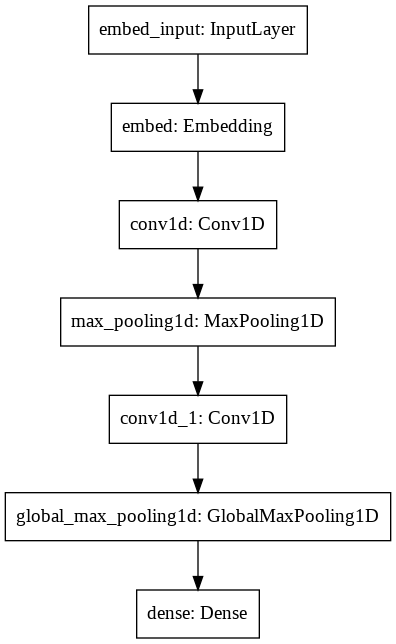

In [ ]:
# 모델의 층 그래프 그리기
from keras.utils import plot_model

plot_model(model, to_file='model.png')

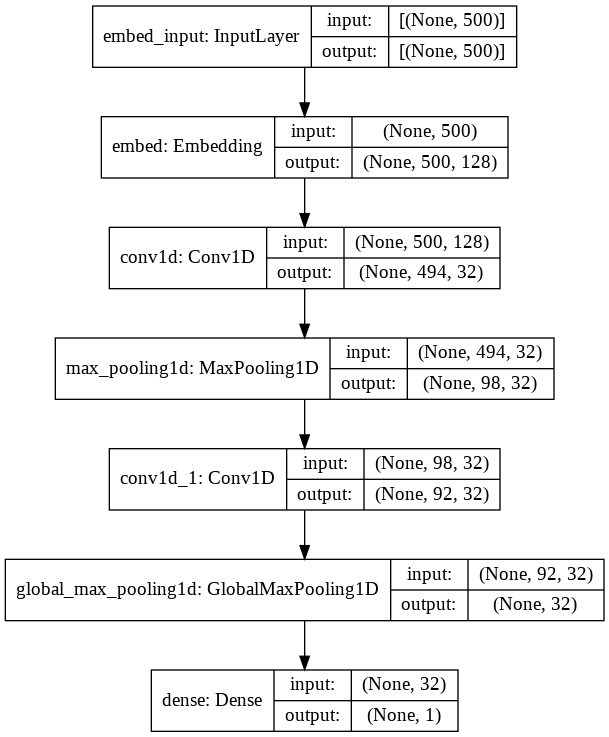

In [ ]:
# 층 그래프에 크기 정보 추가
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='model.png')

## 7.3 모델의 성능을 최대로 끌어올리기


### 고급 구조 패턴
디자인 패턴
- 정규화
- 깊이별 분리 합성곱

이 패턴은 고성능 심층 컨브넷을 만들 때 유용

#### 배치 정규화
**정규화**  
- 머신 러닝 모델에 주입되는 샘플들을 균인하게 만드는 광범위한 방법  

데이터에서 평균을 빼서 데이터를 원점에 맞추고 표준 편차로 나눠 데이터의 분산을 1로 만드는 과정  
```python
normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)
```
이전 예제에서는 모델에 데이터를 주입하기 전에 정규화를 진행 함  
하지만, 데이터 정규화는 네트워크에서 일어나는 모든 변환 후에도 고려 되어야 함  

이를 고려하여 제안된 것이 배치 정규화  
훈련 동안 평균과 분산이 바뀌더라도 이에 적응하여 데이터를 정규화 시키는 방법   

배치 정규화의 효과
- 그래디언트의 전파를 도움  

In [ ]:
conv_model.add(layers.Conv2D(32, 3, activation='relu'))
conv_model.add(layers.BatchNormalization())

dense_model.add(layers.Dense(32, activation='relu'))
dense_model.add(layers.BatchNormalization())

#### 깊이별 분리 합성곱
**입력 채널별로 따로따로 공간 방향의 합성곱을 수행**  
- 공간 특성의 학습과 채널 방향 특성의 학습을 분리하는 효과를 나타냄  

In [3]:
from keras.models import Sequential, Model
from keras import layers

height = 64
width = 64
channels = 3
num_classes = 10

model = Sequential()
model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height, width, channels,)))
model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [4]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_2 (Separabl (None, 62, 62, 32)        155       
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 60, 60, 64)        2400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 28, 28, 64)        4736      
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 26, 26, 128)       8896      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
separable_conv2d_6 (Separabl (None, 11, 11, 64)       

### 하이퍼파라미터 최적화
하이퍼파라미터 최적화 과정
1. 일련의 하이퍼파라미터를 (자동으로) 선택
2. 선택된 하이퍼파라미터로 모델을 만듦
3. 훈련 데이터에 학습하고 검증 데이터에서 최종 성능을 측정
4. 다음으로 시도할 하이퍼파라미터를 (자동으로) 선택
5. 위의 과정 반복
6. 마지막으로 테스트 데이터에서 성능 측정

주어진 하이퍼파라미터에서 얻은 검증 성능을 사용하여 다음 번에 시도할 하이퍼파라미터를 선택하는 알고리즘 종류
- 베이지안 최적화
- 유전 알고리즘
- 간단한 랜덤 탐색
- Hyperopt 라이브러리




### 모델 앙상블
**여러 개 다른 모델의 예측을 합쳐서 더 좋은 예측을 만드는 기법**  
- 독립적으로 훈련된 다른 종류의 좋은 모델이 각기 다른 장점을 갖고 있다는 가정을 바탕으로 함  
- 각 모델들의 관점으로 데이터를 바라보고 이를 합쳐 정확도를 높이는 방법  